In [7]:
from math import *
import matplotlib.pyplot as plt

def EucDist(X, Y):
    return sqrt(sum([ (x-y)**2 for x,y in zip(X,Y) ]))

In [8]:
def sd(data):
    n = len(data)

    if n <= 1:
        return 0.0

    mean, sd = avg(data), 0.0

    # calculate stan. dev.
    for el in data:
        sd += (float(el) - mean)**2
    sd = sqrt(sd / float(n-1))

    return sd

def avg(ls):
    n, mean = len(ls), 0.0

    if n <= 1:
        return ls[0]

    # calculate average
    for el in ls:
        mean = mean + float(el)
    mean = mean / float(n)

    return mean


In [9]:
def AlignPieces_Curvature(X, Y, m, n, mode = 'max distance', cutoff = 0,
             dist_score = False, mean = 90, sd = 36): 
    
    # places to store maximum score and which position
    mx = 0.0
    mx_x = 0
    mx_y = 0
    
    # store the suffix table
    SuffTable = [[0 for k in range(n+1)] for l in range(m+1)] 
      
    # Build suffix table 
    for i in range(m + 1): 
        for j in range(n + 1): 
            if (i == 0 or j == 0): 
                SuffTable[i][j] = 0
            else:
                d = EucDist(X[i-1], Y[j-1])
                if mode == 'max distance': #return actual distances - used to establish cutoff
                    SuffTable[i][j] = d
                elif mode == 'min distance': #return actual distances - used to establish cutoff
                    SuffTable[i][j] = 1/d
                elif mode == 'NW_align': # Needleman-Wunsch - global alignment
                    if d < cutoff: 
                        SuffTable[i][j] = SuffTable[i-1][j-1] + 1
                    else: #ignore distances above cutoff
                        SuffTable[i][j] = SuffTable[i-1][j-1] - 1
                elif mode == 'SW align': #Smith-Waterman - local alignment
                    if dist_score:
                        qtile = (d-mean)/sd
                        SuffTable[i][j] = SuffTable[i-1][j-1] - qtile
                    else:
                        if d < cutoff: 
                            SuffTable[i][j] = SuffTable[i-1][j-1] + 1
                        else: #ignore distances above cutoff
                            SuffTable[i][j] = SuffTable[i-1][j-1] - 1
                    SuffTable[i][j] = max(0,SuffTable[i][j])
                
                # store max value and location
                if SuffTable[i][j] > mx:
                    mx = SuffTable[i][j]
                    mx_x = i
                    mx_y = j
        
    return SuffTable, mx, mx_x, mx_y 

In [10]:
# Load pieces
C_order_pts = {}
C_dists = []
fin = open('C_dists.csv', 'r')
for i,l in enumerate(fin):
    tok = l.rstrip().split(',')
    C_order_pts[i] = int(tok[0]) # inferring order from distance list
    C_dists.append( [float(v) for v in tok[1:]] )
fin.close()

N_order_pts = {}
N_dists = []
fin = open('N_dists.csv', 'r')
for i,l in enumerate(fin):
    tok = l.rstrip().split(',')
    N_order_pts[i] = int(tok[0]) # inferring order from distance list
    N_dists.append( [float(v) for v in tok[1:]] )
fin.close()

S_order_pts = {}
S_dists = []
fin = open('S_dists.csv', 'r')
for i,l in enumerate(fin):
    tok = l.rstrip().split(',')
    S_order_pts[i] = int(tok[0]) # inferring order from distance list
    S_dists.append( [float(v) for v in tok[1:]] )
fin.close()

C_pts = {}
fin = open('C_border_ordered.csv')
h = fin.readline()
for i,l in enumerate(fin):
    tok = l.rstrip().split(',')
    C_pts[i] = {}
    C_pts[i]['x'] = int(tok[0])
    C_pts[i]['y'] = int(tok[1])
fin.close()

N_pts = {}
fin = open('N_border_ordered.csv')
h = fin.readline()
for i,l in enumerate(fin):
    tok = l.rstrip().split(',')
    N_pts[i] = {}
    N_pts[i]['x'] = int(tok[0])
    N_pts[i]['y'] = int(tok[1])
fin.close()

S_pts = {}
fin = open('S_border_ordered.csv')
h = fin.readline()
for i,l in enumerate(fin):
    tok = l.rstrip().split(',')
    S_pts[i] = {}
    S_pts[i]['x'] = int(tok[0])
    S_pts[i]['y'] = int(tok[1])
fin.close()

252.84059625453443 131 34


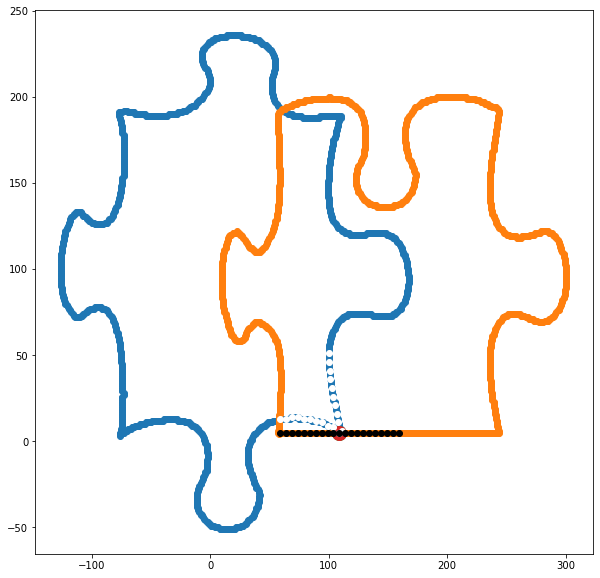

In [19]:
%matplotlib inline

#query piece
Q_pts = C_pts
Q_order_pts = C_order_pts
Q_dists = C_dists

#target piece
T_pts = N_pts
T_order_pts = N_order_pts
T_dists = N_dists

SuffTable, mx, mx_x, mx_y = AlignPieces_Curvature(Q_dists, T_dists[::-1], 
                                     len(Q_dists), len(T_dists),
                                     mode = 'max distance', cutoff = 30,
                                     dist_score = False, mean = 90, sd = 36)
print(mx, mx_x, mx_y)

# find the best matched point - this is the end of the best match window
Q_pt = Q_order_pts[list(Q_order_pts.keys())[mx_x-1]]
T_pt = T_order_pts[list(T_order_pts.keys())[::-1][mx_y-1]] 

# determine the coordinate shift to show the alignment
Q_xshift = Q_pts[Q_pt]['x'] - T_pts[T_pt]['x']
Q_yshift = Q_pts[Q_pt]['y'] - T_pts[T_pt]['y'] 

# plot the pieces, aligned at the maximum scoring point
plt.figure(figsize = [10,10])
plt.scatter( [Q_pts[k]['x'] - Q_xshift for k,v in Q_pts.items() ],
             [Q_pts[k]['y'] - Q_yshift for k,v in Q_pts.items() ])
plt.scatter( [T_pts[k]['x'] for k,v in T_pts.items() ],
             [T_pts[k]['y'] for k,v in T_pts.items() ])

# show best matched points
plt.scatter( Q_pts[Q_pt]['x'] - Q_xshift, Q_pts[Q_pt]['y'] - Q_yshift, s=196)
plt.scatter( T_pts[T_pt]['x'], T_pts[T_pt]['y'], s=196) 

# show similarity window - the red/green point shows the point of maximum similarity
# based on the suffix table.  The black and white dots are the window around that point
Q_keys = [v for v in range((mx_x-11),(mx_x+10) )]
for i,q in enumerate(Q_keys):
    if q < 0:
        Q_keys[i] += len(Q_order_pts)
    elif q >= len(Q_order_pts):
        Q_keys[i] -= len(Q_order_pts)
Q_window = [Q_order_pts[p] for p in list(Q_order_pts.keys())[ min(Q_keys):max(Q_keys)+1 ] ]
plt.scatter( [Q_pts[p]['x'] - Q_xshift for p in Q_window],
             [Q_pts[p]['y'] - Q_yshift for p in Q_window], c = 'white' )

T_keys = [v for v in range((mx_y-11),(mx_y+10) )]
for i,t in enumerate(T_keys):
    if t < 0:
        T_keys[i] += len(T_order_pts)
    elif t >= len(T_order_pts):
        T_keys[i] -= len(T_order_pts)
T_window = [T_order_pts[p] for p in list(T_order_pts.keys())[::-1][ min(T_keys):max(T_keys)+1 ] ]
plt.scatter( [T_pts[p]['x'] for p in T_window],
             [T_pts[p]['y'] for p in T_window], c = 'black' )

6.403215199843474 47.22316303742786 58.11365824929814 66.81744701755588 75.09036112741889 83.40804008951281 92.79835468664622 103.94218432325097 117.7978209519471 139.61643738912173 252.84059625453443
89.29698768701874 37.307793781712704


(array([ 1018.,  6294., 12151., 10355.,  6416.,  3245.,  1499.,   681.,
          206.,   135.]),
 array([  6.4032152 ,  31.04695331,  55.69069141,  80.33442952,
        104.97816762, 129.62190573, 154.26564383, 178.90938194,
        203.55312004, 228.19685815, 252.84059625]),
 <a list of 10 Patch objects>)

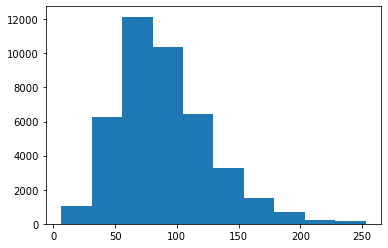

In [12]:
# compute summary statistics on the suffix table
v = []
for i in range(1,len(SuffTable)):
    for j in range(1,len(SuffTable[i])):
        v.append(SuffTable[i][j])
        
v.sort()

l = len(v)
print(min(v), v[int(l*.1)], v[int(l*.2)], v[int(l*.3)], v[int(l*.4)], v[int(l*.5)], 
              v[int(l*.6)], v[int(l*.7)], v[int(l*.8)], v[int(l*.9)], max(v))
print(avg(v), sd(v))
plt.hist(v)

In [224]:
# write out the suffix table - user for external analyses
fout = open('CvsS_SWMatrix_cutoff30.csv', 'w')
for r in SuffTable:
    fout.write(','.join([ str(v) for v in r ]) + '\n')
fout.close()